# Introduction to Landsat pixel quality

 The code snippets in this notebook will let you retrieve the data, mask by using Pixel Quality (pq) and then plot for `ls8_usgs_sr_scene` data.

**What does this document do?**

- Show how to open a datacube to retrieve the data for various time points and geo-coordinates
- Extract the PQ data to be used as mask
- Show the description of flags in a table
- Build up a mask step-by-step from PQ data
- Apply the mask and plot



**Authors**:

Ported to CSIRO Data Cube by CSIRO.

This notebook is derived from the Geoscience Australia, Digital Earth Australia Landsat example notebook developed by: Bex Dunn, Robbi Bishop-Taylor, Mike Barnes, Claire Krause, Damien Ayers, Arapaut Sivaprasad

## Importance of pixel quality

As Landsat Imagery becomes more readily available, there has been a rapid increase in the amount of analyses undertaken by researchers around the globe. In the past, researchers would reject partly cloud-affected scenes in favour of cloud-free scenes. However, Landsat time series analysis using all cloud-free pixels has become a valuable technique and has increased the demand for automation of cloud, cloud shadow and saturation detection. Emergency response applications such as flood mapping typically have to contend with individual cloud affected scenes and therefore rely on effective cloud and cloud shadow removal techniques. The capacity to automatically exclude such pixels is essential for emerging multi-temporal analysis techniques that make use of every quality assured pixel within a time series of observations. [[1](#References)]

## What is PQ? 

PQ is an assessment of each image pixel to determine if it is an unobscured, unsaturated observation of the Earth surface and also whether the pixel is represented in each spectral band. The PQ product allows users to produce masks which can be used to exclude pixels which do not meet their quality criteria from analysis.

There can be different PQ products depending on satellite provider, method for production of surface reflectance and so on:
* Geoscience Australia's Digital Earth Australia produces the PQ25 product which combines established algorithms that detect clouds including the Automated Cloud Cover Assessment (ACCA) and Function of mask (Fmask). ACCA is already widely used within the remote sensing community; it is fast and relatively accurate. Fmask on the other hand is newer, but is rapidly becoming more established, and can provide a more accurate cloud mask than ACCA in certain cloud environments. Similarly, the different sensor designs of Landsat 5 TM, Landsat 7 ETM+, and Landsat 8 OLI all have different sensor saturation characteristics. The PQ25 layer enables users to exclude observations from a given band where the pixels are saturated (exceed the dynamic range of the sensor). The per-band saturation information in PQ allows users to exclude pixels where their specific band of interest is saturated. [[1](#References)]
* USGS has its own PQ products documented in the Landsat Product Guides (e.g. Landsat 8 product guide - https://landsat.usgs.gov/sites/default/files/documents/lasrc_product_guide.pdf). We're going to use the Landsat 8 PQ product in our next few examples so we will talk most about this as we go.

Whilst the PQ products can be different the datacube provides support for them very consistently and they all serve a similar purpose. In an effort to assist the broader uptake to EO data The Committee on Earth Observation Satellites (CEOS) is working on specifications for Analysis Ready Data (ARD) which EO data providers can use to aid users in having geophysically comparable products. That way you can be sure that using data from different provides, be it surface reflectance or pixel quality, can be used together safely.


## Masking Landsat with PQ

### Import modules and libraries
All the modules and libraries below are standard ones available, you have seen this code before 

In [1]:
%matplotlib notebook
# Load modules
import sys
import warnings
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
import matplotlib.pyplot as plt

# Set up datacube to load from
dc = datacube.Datacube(app='Landsat PQ')

/home/jovyan/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Available Landsat PQ products
The `list_products` method in the Datacube class displays the names and details of all available products. In the CDC Lte datacube the PQ data is available as part of the `ls8_usgs_sr_scene`. Some Datacube do this differently an store the PQ data in a separate product, usually postfixed with _pq (e.g. DEA). There are pros and cons to this approach and there is no correct answer. We'll be pedantic and list the products available though it will make no difference in this case (on DEA you would see the extra _pq products):

In [2]:
# Connect to a datacube
dc = datacube.Datacube(app='Intro to Landsat PQ25')

# List metadata for all Landsat NBAR and NBART products available in DEA
dc_products = dc.list_products()
display_columns = ['name', 'description', 'product_type', 'crs', 'resolution', 'spatial_dimensions']
dc_products[dc_products['name'].str.contains("ls8_usgs_sr_albers")][display_columns].set_index('name')

,description,product_type,crs,resolution,spatial_dimensions
name,,,,,
ls8_usgs_sr_albers,"Landsat 8 LaSRC 30 metre, 200km tile, Australi...",LaSRC,EPSG:3577,"(-30, 30)","(y, x)"


## Load Landsat and PQ data

### Specify a *query* with coordinates and date range

In [3]:
# Define temporal and spatial extents to pass to `dc.load` for the data extraction:
query = {'lat': (-35.25, -35.35),
         'lon': (149.05, 149.17),
         'time':('2017-09-04', '2017-09-4')}

### Load Landsat data
In this example we will first load data for the Landsat 8 satellite. Multiple scenes are acquired by the satellite on the same day. We want to group these together, and will use `group_by='solar_day'` to do this. To load in the data, we use our query above to provide a spatial and temporal extraction range, and remove nodata values just like we did in the earlier notebook:

In [4]:
# Load data
ds = dc.load(product='ls8_usgs_sr_albers', group_by='solar_day', **query)

# Get the measurements from the datacube
measurements = dc.list_measurements()
reflectance_measurements = measurements[measurements['units'] == 'reflectance']
dv_names = reflectance_measurements.index.get_level_values('measurement')

# Set all nodata pixels to `NaN` for the data variables in dv_names
ds_nans = masking.mask_invalid_data(ds[dv_names])
# Set all invalid to `NaN` - valid range for USRS SR is 0 to 10000
ds_nans = ds_nans.where((ds_nans >= 0) & (ds_nans<=10000))

ds.update(ds_nans)
ds

<xarray.Dataset>
Dimensions:          (time: 1, x: 410, y: 417)
Coordinates:
  * time             (time) datetime64[ns] 2017-09-04T23:50:24.564670
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) float64 187.0 89.0 69.0 257.0 271.0 431.0 ...
    blue             (time, y, x) float64 233.0 277.0 382.0 518.0 447.0 ...
    green            (time, y, x) float64 481.0 567.0 689.0 806.0 726.0 ...
    red              (time, y, x) float64 580.0 548.0 751.0 1.063e+03 923.0 ...
    nir              (time, y, x) float64 2.115e+03 2.291e+03 2.447e+03 ...
    swir1            (time, y, x) float64 1.357e+03 1.516e+03 1.891e+03 ...
    swir2            (time, y, x) float64 956.0 1.01e+03 1.317e+03 1.277e+03 ...
    pixel_qa         (time, y, x) uint16 322 322 322 322 322 322 322 322 322 ...
    sr_aerosol       (time, y, x) uint8 228 228 224 2

Plot a true colour image using the dataset. Note that a large portion of the image is obscured by cloud:

<IPython.core.display.Javascript object>


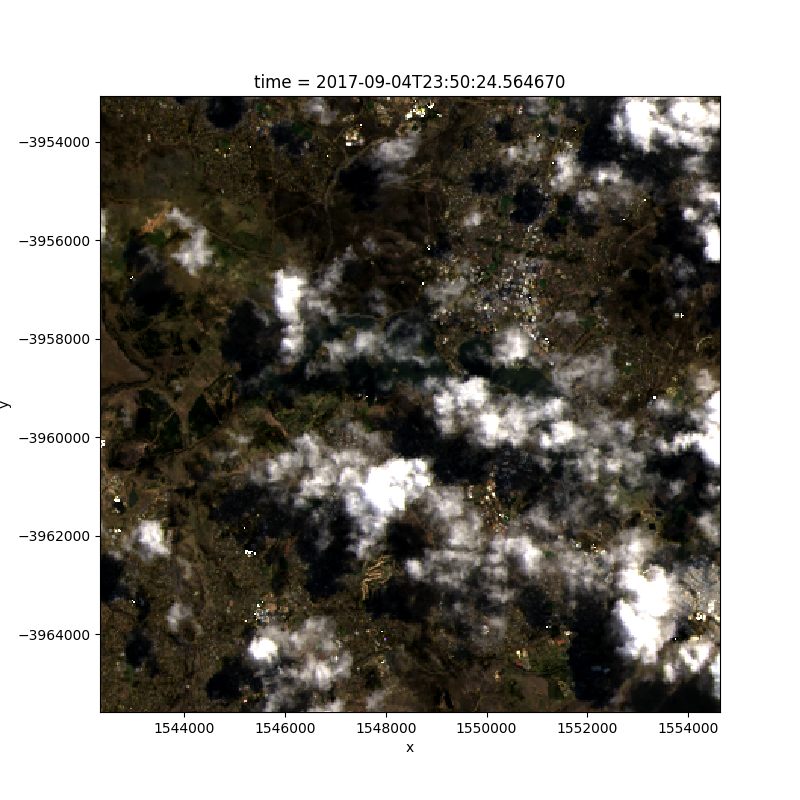

In [5]:
ds[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(robust=True, figsize=(8, 8))

# Masking out clouds using `pixel_qa`

We're going to be using one of our loaded `Data variables` called `pixel_qa` for the masking step.

pixel_qa doesn't convey surface reflectance intensities like the other `Data variables`. Instead, it is a variable that contains more abstract information for each pixel. It places a pixel under one or more of the following categories:

* clear - pixel is likely normal landcover
* water - pixel is likely water
* cloud_shadow - pixel is likely in the shadow of a cloud
* snow - the pixel is likely snowy
* cloud - the pixel is likely cloudy
* fill - the pixel is classified as not fit for analysis (SRC-Gaps in LS7 fall in this classification)

We will use these classifications to mask out values unsuitable for analysis.

Details of the pixel_qa Bit Index can be found in the Landsat 8 product guide - https://landsat.usgs.gov/sites/default/files/documents/lasrc_product_guide.pdf

## A Masking Function

The masking step will have to make use of a very peculiar encoding for each category.


$$\begin{array}{|c|c|}
\hline bit & value & sum & interpretation \\\hline
          0  & 1 & 1 & Fill \\\hline 
        1  & 2 & 3 & Clear \\\hline
        2  & 4 & 7 & Water \\\hline
        3  & 8 & 15 & Cloud Shadow \\\hline
        4  & 16 & 31 & Snow \\\hline
        5  & 32 & 63 & Cloud \\\hline
        6  & 64 & 127 & Cloud Confidence \\
        & & & 00 = None \\
        7 & 128 & 255 & 01 = Low \\
        & & &  10 = Med \\
        & & &  11 = High \\\hline 
        \end{array}$$

and a few others we won't go into now.



As with most things in the datacube you can query for a description of the bit flags as it is in the `pixel_qa` data attributes. This can be a reasonably complex dictionary structure so we are going to leverage the datacube `masking` module to get a neater text printout.

First, lets take a look at the `pixel_qa` variable:

In [6]:
ds.pixel_qa

<xarray.DataArray 'pixel_qa' (time: 1, y: 417, x: 410)>
array([[[322, 322, ..., 352, 352],
        [322, 322, ..., 352, 352],
        ...,
        [322, 322, ..., 352, 352],
        [322, 322, ..., 328, 328]]], dtype=uint16)
Coordinates:
  * time     (time) datetime64[ns] 2017-09-04T23:50:24.564670
  * y        (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x        (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
Attributes:
    units:             bit_index
    nodata:            1
    flags_definition:  {'snow': {'bits': 4, 'values': {'0': 'no_snow', '1': '...
    crs:               EPSG:3577

You can see the data array bit at the bottom you can see the `Attributes` and `flags_definition` contains a description of what each bit means. datacube's `masking` module can print this neatly for us:

In [7]:
from datacube.storage import masking

masking.describe_variable_flags(ds)

,bits,values,description
cirrus_confidence,"[8, 9]","{'0': 'none', '1': 'low', '2': 'medium', '3': ...",NaN
clear,1,"{'0': 'no_clear_land', '1': 'clear_land'}",NaN
cloud,5,"{'0': 'no_cloud', '1': 'cloud'}",NaN
cloud_confidence,"[6, 7]","{'0': 'none', '1': 'low', '2': 'medium', '3': ...",NaN
cloud_shadow,3,"{'0': 'no_cloud_shadow', '1': 'cloud_shadow'}",NaN
nodata,0,"{'0': False, '1': True}",NaN
pixel_qa,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","{'1': 'Fill', '2': 'Clear', '4': 'Water', '8':...",Level 2 Pixel Quality Band
snow,4,"{'0': 'no_snow', '1': 'snow'}",NaN
terrain_occlusion,10,"{'0': 'no_occlusion', '1': 'occlusion'}",NaN
water,2,"{'0': 'no_water', '1': 'water'}",NaN


That's better, you can read it now!

You will notice an additional `pixel_qa` in there which realates to all `bits`. It's actually a repeat of the other information and an alternate form for coding the bit flag metadata. It doesn't have the explicit `values` listed so its a little more difficult to use. We'll use the more useful form in these examples.

In order to mask our data we need a `True/False` value for each pixel in our data variables. We can construct this easily from the PQ information by combining flags. You can make a lot of errors using bit flags directly so the datacube includes a call to create masks in a more human readable form using the `values` listed. We're going to remove all pixels that have cloud or cloud shadow according to the PQ information.

In [8]:
cloud_mask = masking.make_mask(ds.pixel_qa, cloud='no_cloud', cloud_shadow='no_cloud_shadow') 
cloud_mask

<xarray.DataArray 'pixel_qa' (time: 1, y: 417, x: 410)>
array([[[ True,  True, ..., False, False],
        [ True,  True, ..., False, False],
        ...,
        [ True,  True, ..., False, False],
        [ True,  True, ..., False, False]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-09-04T23:50:24.564670
  * y        (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
  * x        (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...

As you can see the resulting `DataArray` is the same shape as the `Dataset ds` and its filled with `True/False`.
A picture says a thousand words so lets plot the first times mask - Yellow is `True` and Purple is `False`


<IPython.core.display.Javascript object>


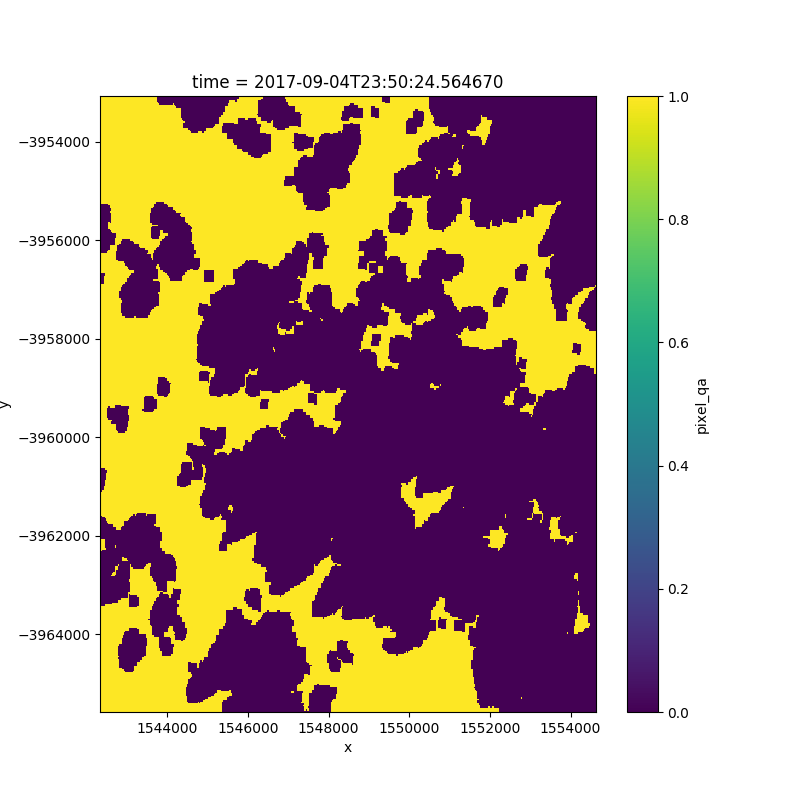

In [9]:
cloud_mask.isel(time=0).plot.imshow(robust=True, figsize=(8, 8))

Creating a cloud free dataset is then a simple case of applying the cloud_mask and setting all the places where there are cloud or cloud shadow to `NaN` - the ds.where() call can do this.

**Important:** we only want to do this to the surface reflectance measurements so we'll reuse the `dv_names` variable we created earlier to restrict our impact to those alone.

In [10]:
ds_cloud_free = ds[dv_names].where(cloud_mask)
ds_cloud_free

<xarray.Dataset>
Dimensions:          (time: 1, x: 410, y: 417)
Coordinates:
  * time             (time) datetime64[ns] 2017-09-04T23:50:24.564670
  * x                (x) float64 1.542e+06 1.542e+06 1.542e+06 1.542e+06 ...
  * y                (y) float64 -3.953e+06 -3.953e+06 -3.953e+06 -3.953e+06 ...
Data variables:
    coastal_aerosol  (time, y, x) float64 187.0 89.0 69.0 257.0 271.0 431.0 ...
    blue             (time, y, x) float64 233.0 277.0 382.0 518.0 447.0 ...
    green            (time, y, x) float64 481.0 567.0 689.0 806.0 726.0 ...
    red              (time, y, x) float64 580.0 548.0 751.0 1.063e+03 923.0 ...
    nir              (time, y, x) float64 2.115e+03 2.291e+03 2.447e+03 ...
    swir1            (time, y, x) float64 1.357e+03 1.516e+03 1.891e+03 ...
    swir2            (time, y, x) float64 956.0 1.01e+03 1.317e+03 1.277e+03 ...
Attributes:
    crs:      EPSG:3577

<IPython.core.display.Javascript object>


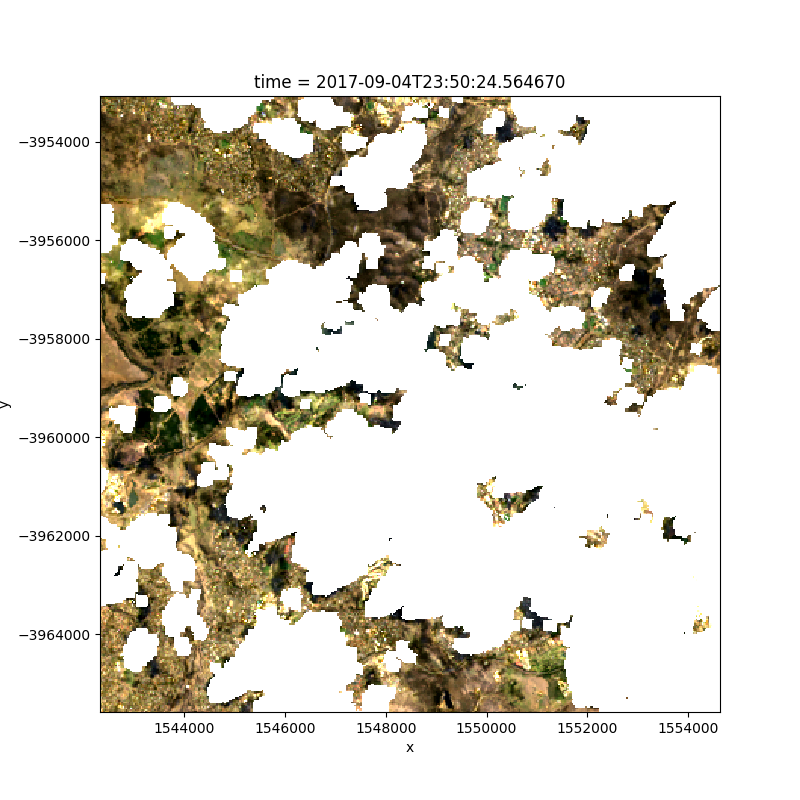

In [11]:
ds_cloud_free[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(robust=True, figsize=(8, 8))

## References
1. GA, 2015. *Pixel Quality (PQ25) Product Description* https://d28rz98at9flks.cloudfront.net/81942/Pixel_Quality_PQ25.PDF